# Fitting File

### Use LightKurve to download original data

In [1]:
import lightkurve as lk
import numpy as np
from astropy.io import fits
from astropy.table import Table
from wotan import flatten
import os
from os.path import join, basename, splitext
from glob import glob
import matplotlib.pyplot as plt
import batman
import corner
import emcee
import pickle
import multiprocessing
from multiprocessing import Pool
#multiprocessing needs this line for set up 
multiprocessing.set_start_method("fork")
os.environ["OMP_NUM_THREADS"] = "1"
%matplotlib inline

In [2]:
#Find the MAST data for the target
search_result = lk.search_lightcurve('TOI 910', author = 'SPOC', cadence = 'short')
lc_collection = search_result.download_all()
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 12,2019,SPOC,120,369327947,0.0
1,TESS Sector 13,2019,SPOC,120,369327947,0.0
2,TESS Sector 27,2020,SPOC,120,369327947,0.0
3,TESS Sector 39,2021,SPOC,120,369327947,0.0
4,TESS Sector 66,2023,SPOC,120,369327947,0.0
5,TESS Sector 67,2023,SPOC,120,369327947,0.0
6,TESS Sector 93,2025,SPOC,120,369327947,0.0
7,TESS Sector 94,2025,SPOC,120,369327947,0.0


In [3]:
#download these LCs as FITS files
output_dir = "LK_lightcurves"
os.makedirs(output_dir, exist_ok=True)

for lc in lc_collection:
    sector = lc.sector
    filename = f"TOI_910_sector_{sector:02d}.fits"
    filepath = os.path.join(output_dir, filename)

    lc.to_fits(filepath, overwrite=True)

In [4]:
#check lc columns
with fits.open("LK_lightcurves/TOI_910_sector_12.fits") as hdu:
    print(hdu[1].columns.names)

['TIME', 'FLUX', 'FLUX_ERR', 'CADENCENO', 'MOM_CENTR1', 'MOM_CENTR2', 'QUALITY']


### Process and detrend data with Wotan

In [5]:
#Wotan uploading functionality 
def load_file(filename):
    """Loads a TESS *spoc* FITS file and returns TIME, PDCSAP_FLUX"""
    hdu = fits.open(filename)
    time = hdu[1].data['TIME']
    flux = hdu[1].data['FLUX']
    flux_err = hdu[1].data['FLUX_ERR']
    flux[flux == 0] = np.nan # makes zero flux values nans
    flux_err[flux_err == 0] = np.nan
    return time, flux, flux_err

Loading TESS data from folder...
starting LK_lightcurves/TOI_910_sector_27.fits
plotting now


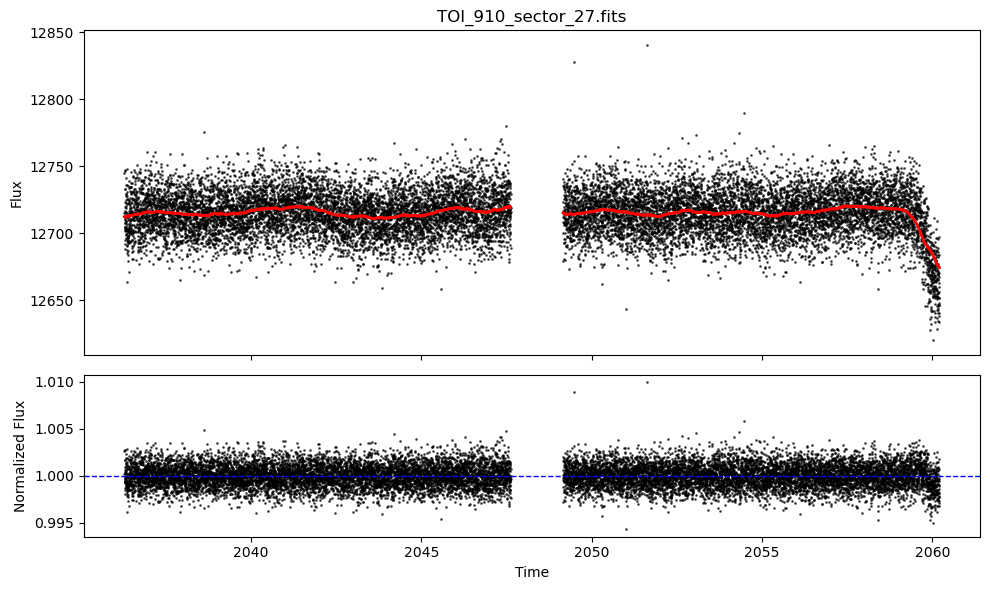

starting LK_lightcurves/TOI_910_sector_66.fits
plotting now


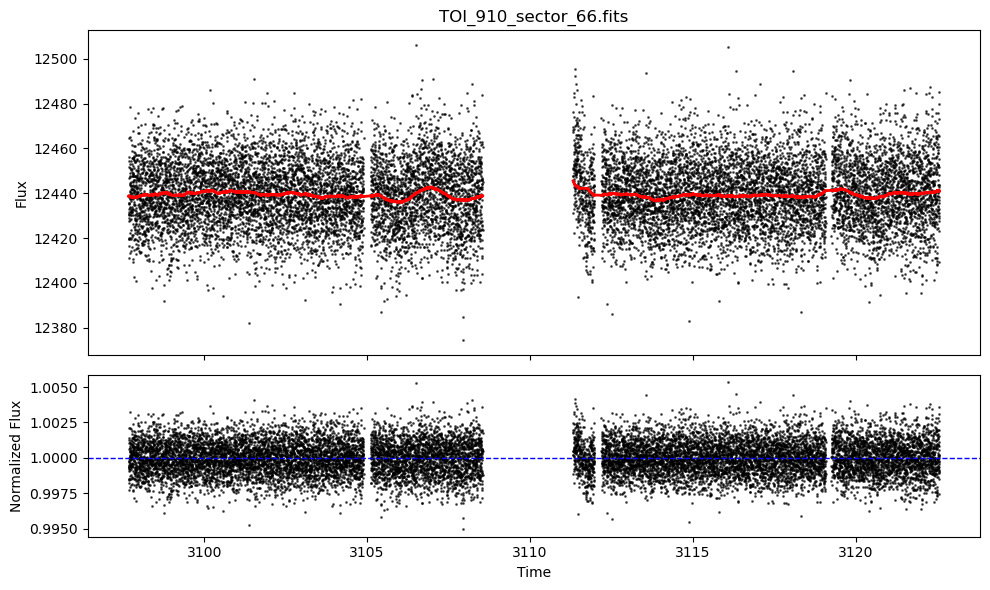

starting LK_lightcurves/TOI_910_sector_93.fits
plotting now


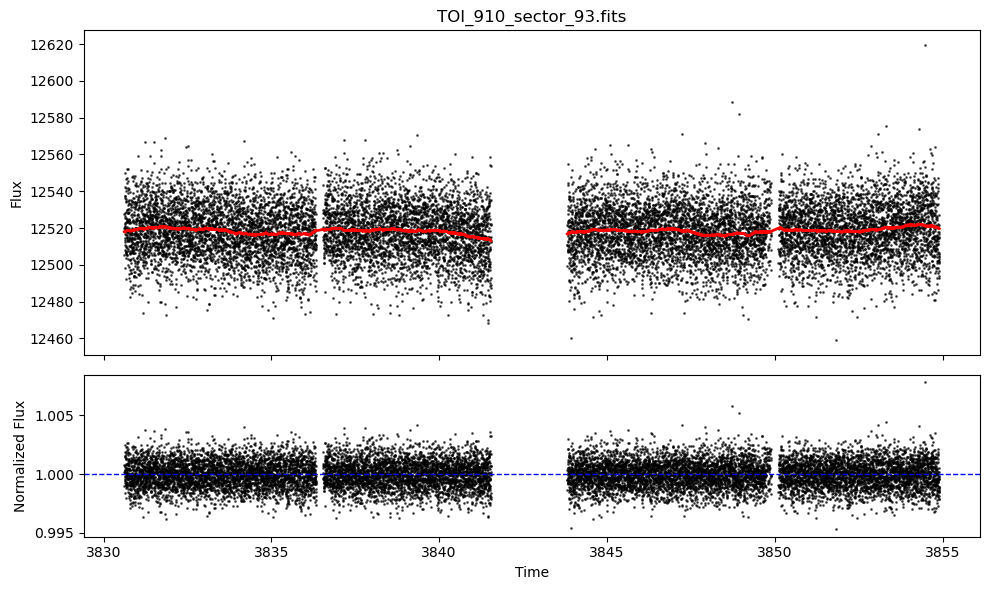

starting LK_lightcurves/TOI_910_sector_67.fits
plotting now


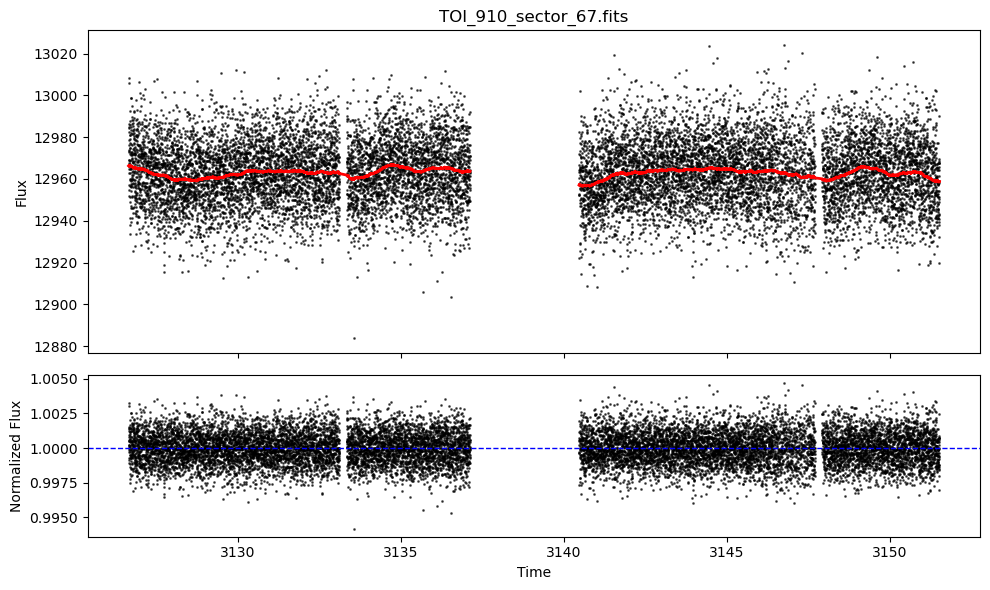

starting LK_lightcurves/TOI_910_sector_94.fits
plotting now


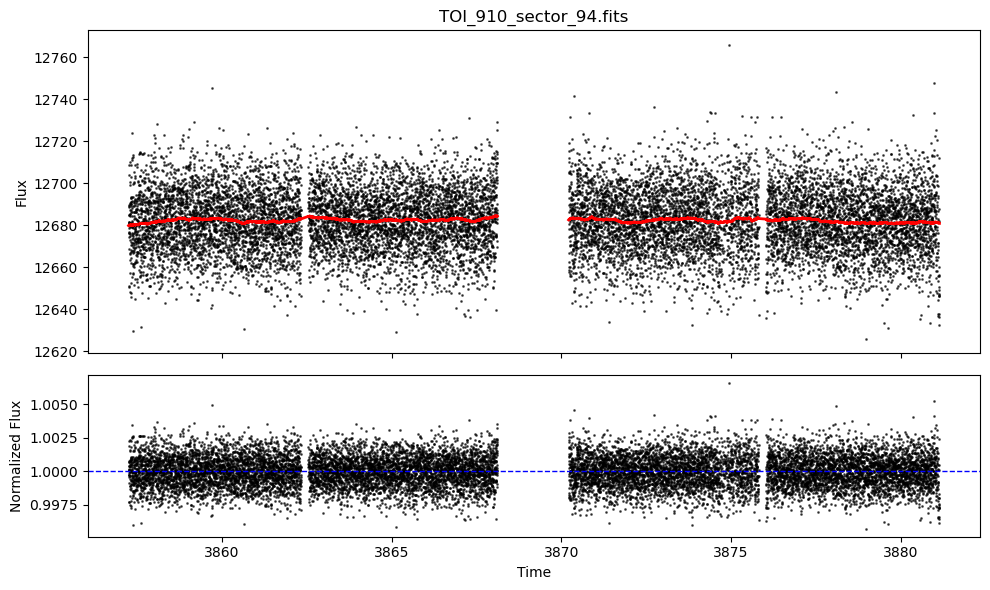

starting LK_lightcurves/TOI_910_sector_39.fits
plotting now


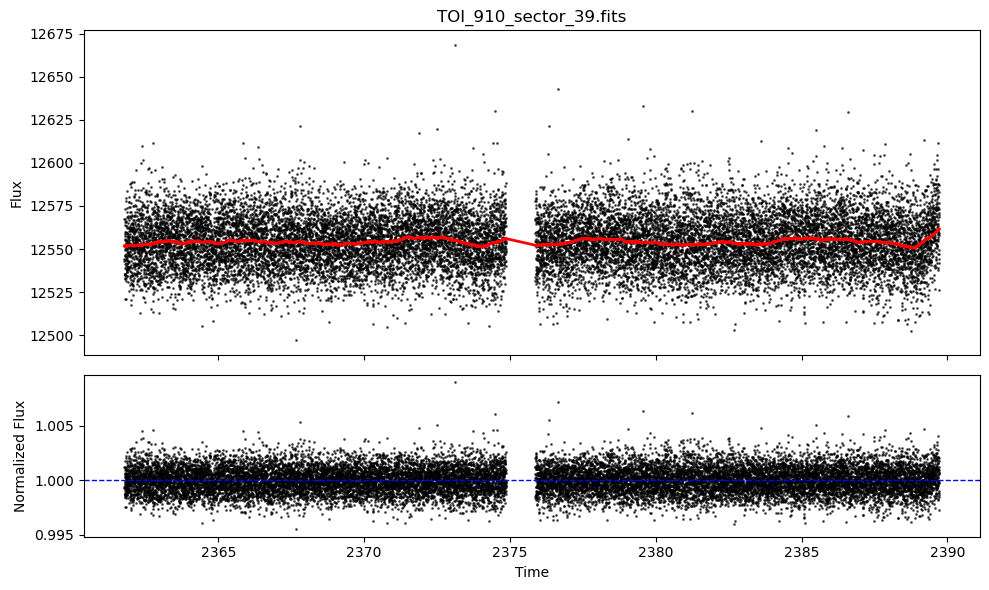

starting LK_lightcurves/TOI_910_sector_13.fits
plotting now


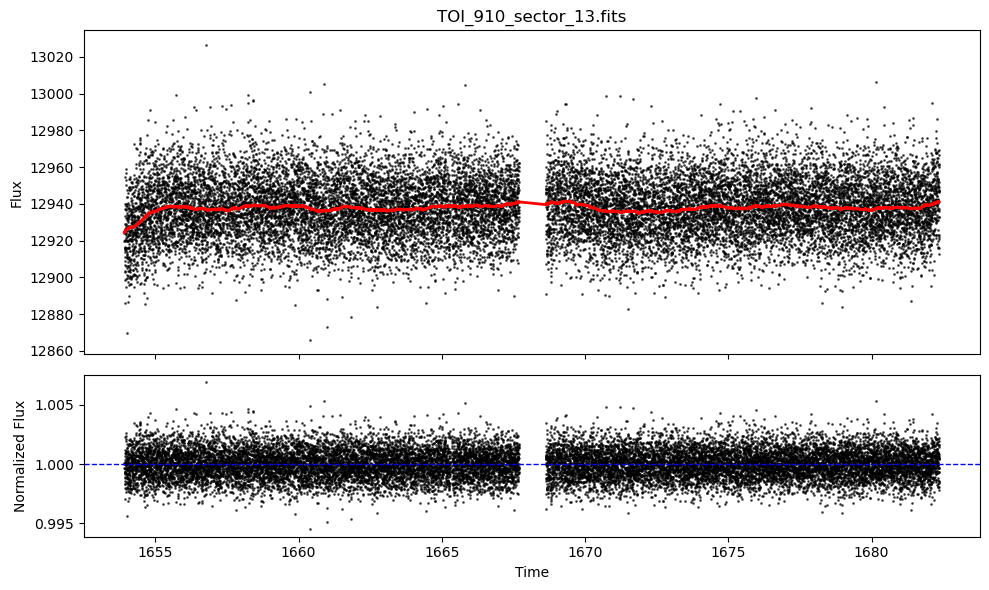

starting LK_lightcurves/TOI_910_sector_12.fits
plotting now


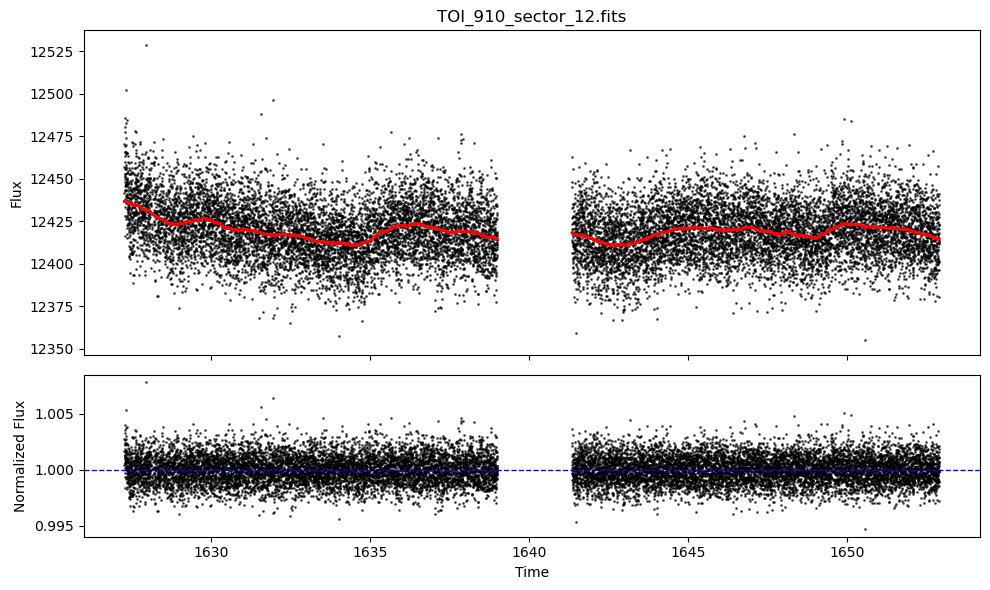

In [6]:
print("Loading TESS data from folder...")

#establishes the files taken in and their destination path after flattening
path = "LK_lightcurves/"
files = glob(os.path.join(path, "*.fits"))
outdir = "flattened_lcs/"  
os.makedirs(outdir, exist_ok=True) #make a flattened_lcs directory

#loading the .fits files from the directory
for filepath in files:
    time, flux, flux_err = load_file(filepath)  # read in files
    print(f"starting {filepath}")

    flattened, trend = flatten(
        time,
        flux,
        window_length= 0.9, #probably can play with this for improving fit
        return_trend=True,
        method="biweight",
    )

    # Save LC with flattened flux overwriting the original, as a new .fits
    #also keeps the trend as an additional column
    name = os.path.splitext(os.path.basename(filepath))[0]

    with fits.open(filepath) as hdul:                           
        tab = Table(hdul[1].data)                               
        tab["FLUX"] = np.asarray(flattened)                
        tab["TREND"] = np.asarray(trend)   
        tab["FLUX_ERR"] = np.asarray(flux_err / trend)
        hdul[1] = fits.BinTableHDU(tab, header=hdul[1].header)  # what is this line doing? 
        hdul.writeto(os.path.join(outdir, f"{name}_flat.fits"),  
                     overwrite=True)                            
    
    print("plotting now")

     # plot setup
    fig, axes = plt.subplots(
        2, 1,
        figsize=(10, 6),
        sharex=True,
        gridspec_kw={"height_ratios": [2, 1]}
    )
    
    # raw + trend
    axes[0].scatter(time, flux, s=1, c="black", alpha=0.6)
    axes[0].plot(time, trend, lw=2, c="red")
    axes[0].set_ylabel("Flux")
    axes[0].set_title(os.path.basename(filepath))

    # flattened
    axes[1].scatter(time, flattened, s=1, c="black", alpha=0.6)
    axes[1].axhline(1.0, color="blue", lw=1, ls="--")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("Normalized Flux")

    plt.tight_layout()
    plt.show()


## Stitching the flattened curves together using LightKurve stitch funciton

Loading flattened data from folder...
read in flattened_lcs/TOI_910_sector_12_flat.fits
read in flattened_lcs/TOI_910_sector_13_flat.fits
read in flattened_lcs/TOI_910_sector_27_flat.fits
read in flattened_lcs/TOI_910_sector_39_flat.fits
read in flattened_lcs/TOI_910_sector_66_flat.fits
read in flattened_lcs/TOI_910_sector_67_flat.fits
read in flattened_lcs/TOI_910_sector_93_flat.fits
read in flattened_lcs/TOI_910_sector_94_flat.fits


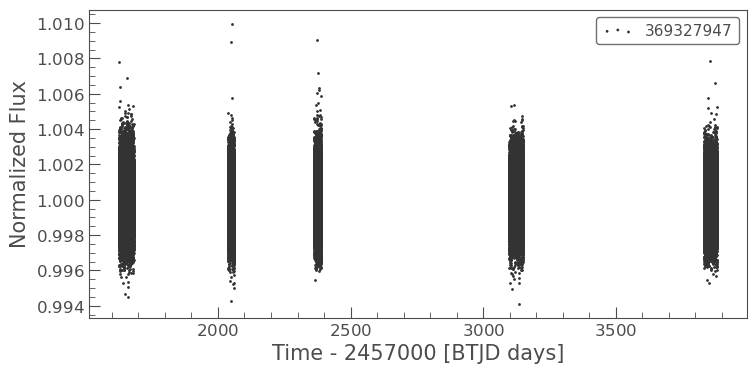

In [7]:
#stitching the flattened lightcurves 
print("Loading flattened data from folder...")

path = "flattened_lcs/"
files = sorted(glob(os.path.join(path, "*_flat.fits")))

lcs = lk.LightCurveCollection([])
for filepath in files:
    lc = lk.read(filepath)
    print(f'read in {filepath}')
    lcs.append(lc)

lc_stitched = lcs.stitch()
lc_stitched.scatter()

#new folder for them to live in
outdir = "stitched_lcs/"
os.makedirs(outdir, exist_ok=True) #make a flattened_lcs directory

lc_stitched.write(os.path.join(outdir, "910_stitched_lc.fits"), overwrite=True)


In [8]:
# checking the new columns for trend info
with fits.open("stitched_lcs/910_stitched_lc.fits") as hdu:
    print(hdu[1].columns.names)

['time', 'flux', 'flux_err', 'cadenceno', 'mom_centr1', 'centroid_col', 'centroid_row', 'mom_centr2', 'quality', 'trend']


## MCMC on Stitched Data

In [9]:
# choose stitched data arrays 
t_data = lc_stitched.time.value 
y_data = lc_stitched.flux.value 

# Flux errors
if hasattr(lc_stitched, "flux_err") and lc_stitched.flux_err is not None:
    yerr = np.asarray(lc_stitched.flux_err.value) 
else:
    yerr = np.full_like(y_data, np.nanstd(y_data - np.nanmedian(y_data)))  

# Mask bad points
mask = np.isfinite(t_data) & np.isfinite(y_data) & np.isfinite(yerr) & (yerr > 0)  
t_data, y_data, yerr = t_data[mask], y_data[mask], yerr[mask] 

# make arrays contiguous in memory to improve speed
t_data = np.ascontiguousarray(t_data)
y_data = np.ascontiguousarray(y_data)
yerr = np.ascontiguousarray(yerr)

In [10]:
#  batman model 
def make_model_flux(t, t0, per, rp, a, inc, u1=0.1, u2=0.3): 
    p = batman.TransitParams()
    p.t0 = t0
    p.per = per
    p.rp = rp
    p.a = a
    p.inc = inc
    p.ecc = ecc_fixed
    p.w = w_fixed
    p.limb_dark = "quadratic"
    p.u = [u1, u2]

    m = batman.TransitModel(p, t)
    return m.light_curve(p)
    


In [11]:
# fixed parameters 
ecc_fixed = 0.0  
w_fixed   = 90.0 
fit_ld = False 

In [12]:
# Old functions 

# # flat priors 
# def log_prior(theta):  
#     t0, per, rp, a, inc = theta

#     if not (1626.0 < t0 < 1627.0):
#         return -np.inf
#    gvs
#     if not (0.001 < rp < 0.5):
#         return -np.inf
#     if not (1.0 < a < 100.0):
#         return -np.inf
#     if not (60.0 < inc < 90.0):
#         return -np.inf

#     return 0.0

## Log prob function not using global variables 
# def log_probability(theta, t, y, yerr):
#     lp = log_prior(theta)
#     if not np.isfinite(lp):
#         return -np.inf
#     return lp + log_likelihood(theta, t, y, yerr)


In [13]:
##MCMC Functions

#Gaussian Priors
# means
mu = np.array([1626.204, 2.02909, 0.0326, 15.3, 87.2])

# Choose prior widths (1-sigma).
sigma = np.array([
    0.05,      # t0 (days)  ~14.4 min is 0.01
    1e-4,      # per (days)
    0.005,     # rp
    2.0,       # a
    0.5        # inc (deg)
])

def log_prior(theta):
    t0, per, rp, a, inc = theta

    # (Optional but recommended) keep physical bounds as hard cutoffs
    if not (0.001 < rp < 0.5):
        return -np.inf
    if not (1.0 < a < 100.0):
        return -np.inf
    if not (60.0 < inc < 90.0):
        return -np.inf

    # Gaussian log prior (ignore additive constants)
    x = np.array([t0, per, rp, a, inc])
    return -0.5 * np.sum(((x - mu) / sigma) ** 2)

# likelihood 
def log_likelihood(theta, t, y, yerr): 
    t0, per, rp, a, inc = theta
    model = make_model_flux(t, t0, per, rp, a, inc)

    if not np.all(np.isfinite(model)):
        return -np.inf

    resid = y - model
    inv_sigma2 = 1.0 / (yerr**2)
    return -0.5 * np.sum(resid**2 * inv_sigma2 + np.log(2*np.pi*yerr**2))
    
#global variables means faster runnning
def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t_data, y_data, yerr)


In [14]:
# MCMC setup wtih AUTOSTOP

initial = np.array([
    1626.204,    # t0
    2.02909,    # period
    0.0326,     # Rp/Rs
    15.3,       # a/Rs
    87.2        # inc
])

nwalkers = 25
ndim = len(initial)

scales = np.array([1e-4, 1e-6, 1e-4, 1e-3, 1e-3]) #this is creating the randomness for the walkers
pos = initial + scales * np.random.randn(nwalkers, ndim) #setting the walkers to start at random, gaussian ball


# Autostop set up
max_steps = 80000  # if not reaching stop, max steps
convergence_check_start = 5000  # start checking convergence at this point
convergence_check_interval = 500  # check every this many intervals-- checking too often is expensive
tau_mult = 50  # require N > tau_mult * tau 
tau_rel_change = 0.01  # tau stable to 1% 
autocorr_history = {}  # store tau vs iteration for diagnostics 
old_tau = np.inf  # previous tau for stability check


#multiprocessing the walker chains
with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability,
        # args=(t_data, y_data, yerr), #only need this line when not using global variable version
        pool=pool
    )

    # Run with autostop
    for _ in sampler.sample(pos, iterations=max_steps, progress=True): 
        it = sampler.iteration 

        # only check every convergence_check_interval steps 
        if it % convergence_check_interval != 0: #% is remainder-- checking for multiples of interval steps
            continue 

        # don't check too early  
        if it < convergence_check_start:  
            continue  

        # estimate autocorrelation time 
        try:  
            tau = sampler.get_autocorr_time(tol=0)  
        except Exception: 
            # chain too short / tau not reliable yet  
            continue 

        autocorr_history[it] = tau.copy() 

        # convergence criteria  
        chain_long_enough = np.all(it > tau_mult * tau)  
        tau_stable = np.all(np.isfinite(old_tau)) and np.all(np.abs(old_tau - tau) / tau < tau_rel_change)

        if chain_long_enough and tau_stable:  
            print(f"Converged at iteration {it} (mean tau={np.mean(tau):.1f}, max tau={np.max(tau):.1f})")  
            break  #stops if necessary!

        old_tau = tau 


  7%|███████▊                                                                                                         | 5500/80000 [01:10<15:48, 78.51it/s]

Converged at iteration 5500 (mean tau=60.3, max tau=78.1)


In [15]:
# posterior
burnin = int(2*np.max(tau))
samples = sampler.get_chain(discard=burnin, flat=True)
t0_s, per_s, rp_s, a_s, inc_s = samples.T


In [16]:
# # MCMC setup pool no autostop

# initial = np.array([
#     1626.204,    # t0
#     2.02909,    # period
#     0.0326,     # Rp/Rs
#     15.3,       # a/Rs
#     87.2        # inc
# ]) 

# nwalkers = 25 
# ndim = len(initial) 

# scales = np.array([1e-4, 1e-5, 1e-4, 1e-3, 1e-3]) #this is creating the randomness for the walkers
# pos = initial + scales * np.random.randn(nwalkers, ndim) #setting the walkers to start at random, gaussian ball

# #multiprocessing the walker chains
# with Pool() as pool:
#     sampler = emcee.EnsembleSampler(
#         nwalkers, ndim, log_probability,
#         # args=(t_data, y_data, yerr), #only need this line when not using global variable version
#         pool = pool
#     ) 
#     sampler.run_mcmc(pos, 80000, progress=True)

# # posterior 
# burnin = 3000
# samples = sampler.get_chain(discard=burnin, flat=True)  
# t0_s, per_s, rp_s, a_s, inc_s = samples.T 


In [17]:
# # MCMC setup without pool

# initial = np.array([
#     1626.204,    # t0
#     2.02909,    # period
#     0.0326,     # Rp/Rs
#     15.3,       # a/Rs
#     87.2        # inc
# ]) 

# nwalkers = 25 
# ndim = len(initial) 

# scales = np.array([1e-4, 1e-6, 1e-4, 1e-3, 1e-3])
# pos = initial + scales * np.random.randn(nwalkers, ndim)


# sampler = emcee.EnsembleSampler(
#     nwalkers, ndim, log_probability,
#     # args=(t_data, y_data, yerr) # uncomment if using non-global variables
#     pool = pool
# ) 

# sampler.run_mcmc(pos, 80000, progress=True)

# # posterior 
# burnin = 3000
# samples = sampler.get_chain(discard=burnin, flat=True)  
# t0_s, per_s, rp_s, a_s, inc_s = samples.T 


## Convergence Diagnostics

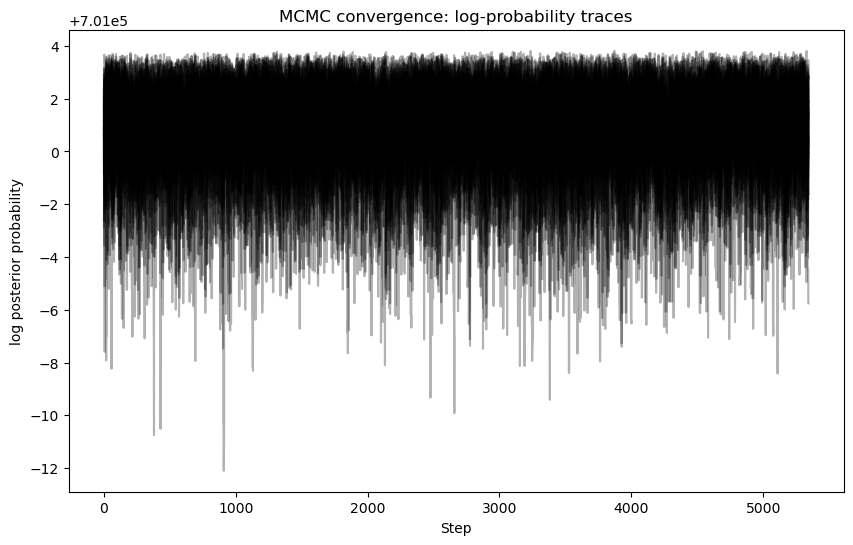

In [18]:
# Log-probability chains (keep walkers separate)
log_prob_samples = sampler.get_log_prob(discard=burnin, flat=False) 

nsteps, nwalkers = log_prob_samples.shape 

fig, ax = plt.subplots(1, figsize=(10, 6))

for i in range(nwalkers):  # loop over walkers
    ax.plot(log_prob_samples[:, i], color="k", alpha=0.3)

ax.set_xlabel("Step")
ax.set_ylabel("log posterior probability")
ax.set_title("MCMC convergence: log-probability traces")

plt.show()


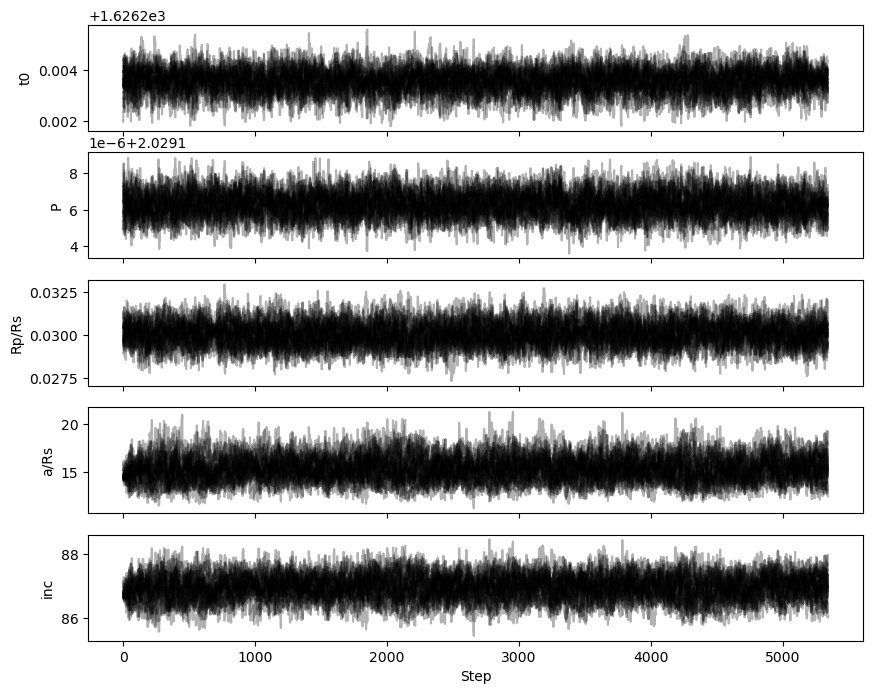

In [19]:
#Chains analysis
chain = sampler.get_chain(discard=burnin, flat=False)

labels = ["t0", "P", "Rp/Rs", "a/Rs", "inc"]

fig, axes = plt.subplots(len(labels), figsize=(10, 8), sharex=True)

for j in range(len(labels)):
    for i in range(nwalkers):
        axes[j].plot(chain[:, i, j], color="k", alpha=0.3)
    axes[j].set_ylabel(labels[j])

axes[-1].set_xlabel("Step")
plt.show()


In [20]:
#Mean Acceptance Fraction
print("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))


Mean acceptance fraction: 0.5306545454545455


In [21]:
#Autocorrelation Time
try:
    tau = sampler.get_autocorr_time()
    print("Autocorrelation times:", tau)
    print("Steps per tau:", sampler.iteration / tau)
except Exception as e:
    print("Autocorr time not reliable yet:", e)


Autocorrelation times: [55.07772275 38.50925606 54.92945306 78.1393591  75.00884167]
Steps per tau: [ 99.85888533 142.82280581 100.12843189  70.38706311  73.32468916]


## Plots of results

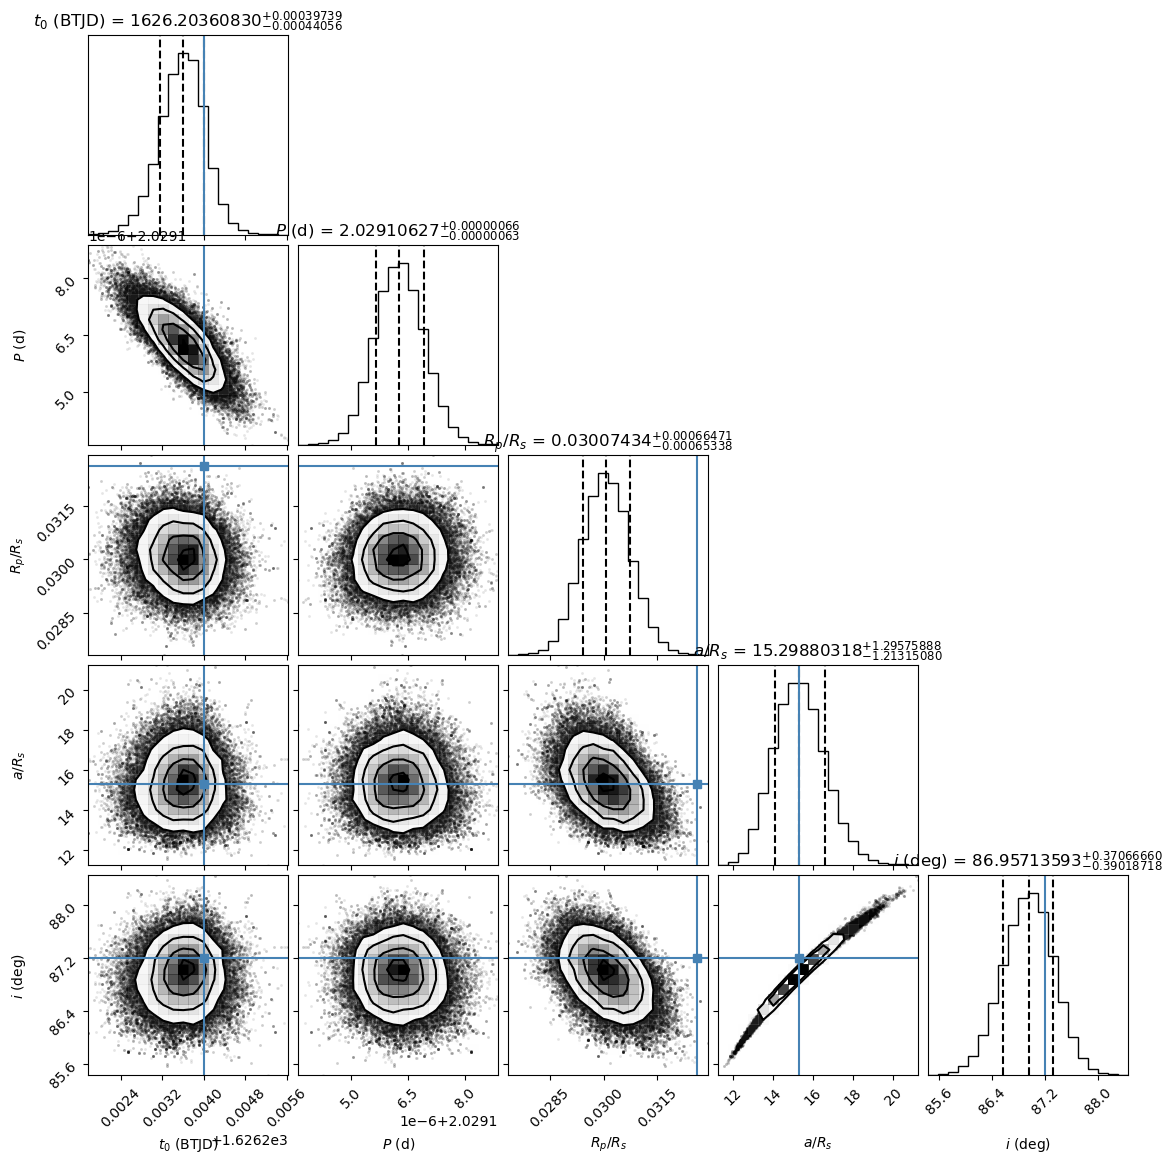

<Figure size 640x480 with 0 Axes>

In [22]:
#Corner Plot
# Use the samples you already made above
# samples = sampler.get_chain(discard=burnin, flat=True)  # (already done)

samples_per = np.column_stack([samples])

labels = [r"$t_0$ (BTJD)", r"$P$ (d)", r"$R_p/R_s$", r"$a/R_s$", r"$i$ (deg)", r"$b$"] 

fig = corner.corner(
    samples_per, 
    labels=labels, 
    show_titles=True, 
    title_fmt=".8f", 
    quantiles=[0.16, 0.5, 0.84], 
    truths = initial
) 

#save plot
outdir = "stitched_lcs/" 
os.makedirs(outdir, exist_ok=True) 
plt.show()
plt.savefig(os.path.join(outdir, "stitched_corner_plot.png"), dpi=200, bbox_inches="tight") 

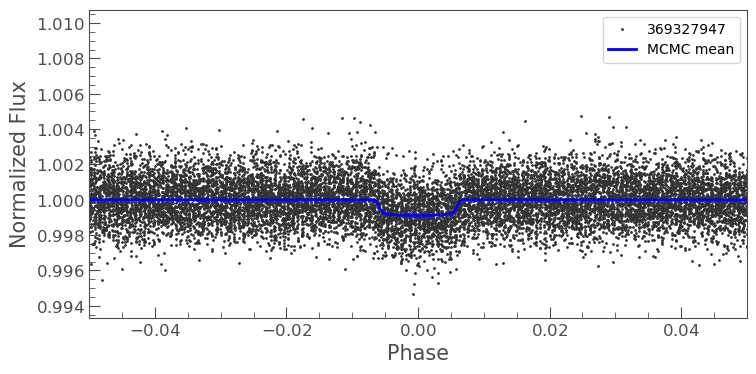

In [23]:
#batman model plot
# Pull mean params from the MCMC posterior
t0_mean  = np.mean(t0_s)  
per_mean = np.mean(per_s) 
rp_mean  = np.mean(rp_s) 
a_mean   = np.mean(a_s) 
inc_mean = np.mean(inc_s)

#Initialize batman params
params = batman.TransitParams() 
params.t0 = t0_mean  
params.per = per_mean 
params.rp = rp_mean 
params.a = a_mean  
params.inc = inc_mean  
params.ecc = 0.0 
params.w = 90.0 
params.u = [0.1, 0.3] 
params.limb_dark = "quadratic" 

# Build a phase grid matching your plot x-axis
phase = np.linspace(-0.5, 0.5, 2000)

# Convert phase to time using the fitted t0 and period 
t_model = t0_mean + phase * per_mean 

# Evaluate batman model 
m = batman.TransitModel(params, t_model) 
model_flux = m.light_curve(params)  

# Fold stitched light curve using fitted t0 
lc_f = lc_stitched.fold(per_mean, epoch_time=t0_mean, normalize_phase=True)
ax = lc_f.scatter() 

# Overlay model in phase space
ax.plot(phase, model_flux, lw=2, color="blue", label="MCMC mean") 

ax.set_xlim(-0.1, 0.1) 
ax.legend() 

# Save plot
outdir = "stitched_lcs/"  
os.makedirs(outdir, exist_ok=True) 
plt.savefig(os.path.join(outdir, "stitched_folded_model.png"), dpi=200, bbox_inches="tight") 
plt.xlim(-0.05,0.05)
plt.show()

